# Imorting Files

In [1]:
import pandas as pd

In [2]:
links = pd.read_csv('csv_files/links.csv')

In [3]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
movies = pd.read_csv('csv_files/movies.csv')

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings = pd.read_csv('csv_files/ratings.csv')

In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
tags =  pd.read_csv('csv_files/tags.csv')

In [9]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [10]:
new_df = ratings.drop(columns='timestamp')

# Recommendation System

In [11]:
from surprise import Reader, Dataset
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [15]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(new_df[['userId', 'movieId', 'rating']], reader)

## Chosing Prediction Algorithms

In [14]:

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.868845,882.926506,32.773629
BaselineOnly,0.876045,0.222493,0.456649
SVD,0.879474,9.959715,0.614917
KNNBaseline,0.881853,0.539366,7.746760
KNNWithMeans,0.905121,0.386333,6.592975
KNNWithZScore,0.905275,0.452219,6.905525
SlopeOne,0.912581,6.849113,21.746805
NMF,0.934993,11.795354,0.525171
CoClustering,0.955518,5.107392,0.581912


## Fine Tunning Parameters

In [16]:
# Fine tuning paramaters
param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                             'reg': [0.2, 0.4, 0.6],
                             'reg_i': [5,10,15],
                             'reg_u' : [10,15,20],
                             'learning_rate': [0.003, 0.005, 0.008],
                             'n_epochs': [75,100,125]}}

In [123]:
gs = GridSearchCV(BaselineOnly, param_grid = param_grid , measures=['rmse'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

In [16]:
print('Using ALS')
bsl_options = {'method': 'als',
               'reg': 0.2,
               'n_epochs': 100,
               'reg_u': 10,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.87027698, 0.86872794, 0.87027064]),
 'fit_time': (1.760714054107666, 1.7705249786376953, 1.7838492393493652),
 'test_time': (0.4569392204284668, 0.4583621025085449, 0.45493626594543457)}

In [17]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.8719


0.8719213501656143

## Top 5 Recommendations

In [18]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['est'] =  round(df['est'] * 2) / 2
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [19]:
df = pd.merge(df, movies, left_on = 'iid', right_on = 'movieId')

In [20]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [21]:
 df.loc[df['uid'] == 1].sort_values(by='err').head()

,uid,iid,rui,est,details,Iu,Ui,err,movieId,title,genres
9424,1,1291,5.0,5.0,{'was_impossible': False},180,106,0.0,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
20112,1,3744,4.0,4.0,{'was_impossible': False},180,15,0.0,3744,Shaft (2000),Action|Crime|Thriller
16521,1,2478,4.0,4.0,{'was_impossible': False},180,17,0.0,2478,¡Three Amigos! (1986),Comedy|Western
13354,1,3,4.0,4.0,{'was_impossible': False},180,37,0.0,3,Grumpier Old Men (1995),Comedy|Romance
11142,1,2959,5.0,5.0,{'was_impossible': False},180,163,0.0,2959,Fight Club (1999),Action|Crime|Drama|Thriller


# Cold Start #1

User rates list of movies and is given recommendations based on input

In [22]:
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list     

In [23]:
user_rating = movie_rater(movies, 4, 'Action')

      movieId                                              title  \
1154     1517  Austin Powers: International Man of Mystery (1...   

                       genres  
1154  Action|Adventure|Comedy  
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
      movieId                           title                         genres
1009     1320  Alien³ (a.k.a. Alien 3) (1992)  Action|Horror|Sci-Fi|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
      movieId                            title  \
1044     1356  Star Trek: First Contact (1996)   

                                genres  
1044  Action|Adventure|Sci-Fi|Thriller  
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
      movieId                                title                  genres
8156   102338  Shaolin Temple (Shao Lin si) (1976)  Action|Adventure|Drama
How do you rate this movie on a scale of 1-5, press n if you have not seen 

In [24]:
new_ratings_df = new_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [25]:
# train a model using the new combined DataFrame
baseline = BaselineOnly(bsl_options=bsl_options)
baseline.fit(new_data.build_full_trainset())

Estimating biases using als...


In [26]:
# make predictions for the user
# you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
list_of_movies = []
for m_id in new_df['movieId'].unique():
    list_of_movies.append( (m_id,baseline.predict(1000,m_id)[3]))

In [27]:
# order the predictions from highest to lowest rated
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [28]:
# return the top n recommendations using the 
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies,5)

Recommendation #  1 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation #  2 :  602    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object 

Recommendation #  3 :  906    Lawrence of Arabia (1962)
Name: title, dtype: object 

Recommendation #  4 :  841    Streetcar Named Desire, A (1951)
Name: title, dtype: object 

Recommendation #  5 :  2226    Fight Club (1999)
Name: title, dtype: object 



# Cold Start #2

Display a list of the most watched movies based on the amount of times the movie has been rated and the average rating of the moive

In [151]:
top = df.groupby('title').mean()

In [152]:
top.drop(['uid', 'est', 'Iu', 'err', 'iid'], axis = 1, inplace = True)

In [153]:
top.sort_values(by = ['Ui', 'rui'], ascending = False).head()

,rui,Ui,movieId
title,,,
"Shawshank Redemption, The (1994)",4.379032,255.0,318.0
Forrest Gump (1994),4.155844,252.0,356.0
Pulp Fiction (1994),4.243421,231.0,296.0
"Silence of the Lambs, The (1991)",4.123188,210.0,593.0
"Matrix, The (1999)",4.175325,201.0,2571.0


# EDA

In [192]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [154]:
top.reset_index(inplace=True)

In [155]:
top['title'] = [top['title'][i].strip() for i in range(len(top))]

In [156]:
top['release_year'] = [top['title'][i][-5:-1] for i in range(len(top))]

In [157]:
top.drop([1147, 1958, 2411], inplace=True)

In [158]:
top['release_year']= top['release_year'].astype(float)

In [161]:
top['decade'] = top['release_year']//10*10

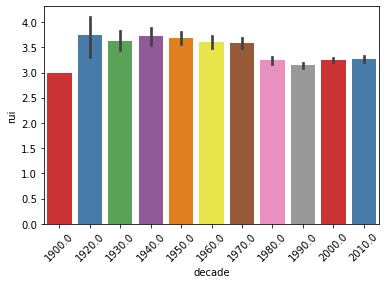

In [163]:
chart = sns.barplot(x='decade', y='rui', data = top, palette = 'Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [164]:
c = top[(top['release_year'] >= 1990)& (top['release_year'] <= 1999)]

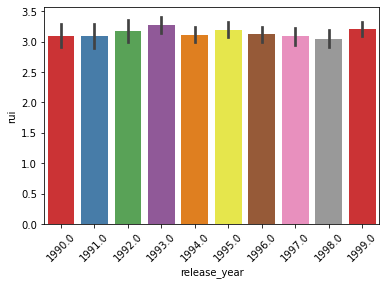

In [167]:
chart = sns.barplot(x='release_year', y='rui', data = c, palette = 'Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

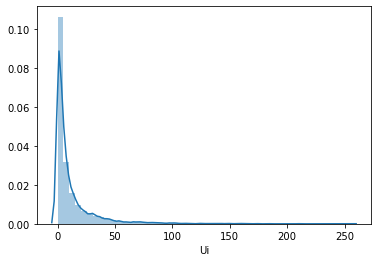

In [207]:
sns.distplot(top['Ui']);

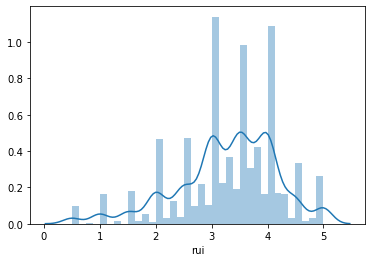

In [261]:
sns.distplot(top['rui']);

In [247]:
print('% unrated movies:')
print(round((len(top[top['Ui'] == 0]) / len(top) * 100), 2))


% unrated movies:
16.53


In [253]:
print('% unrated movies:')
print(round((len(top[top['Ui'] <= 50]) / len(top) * 100), 2))


% unrated movies:
95.12


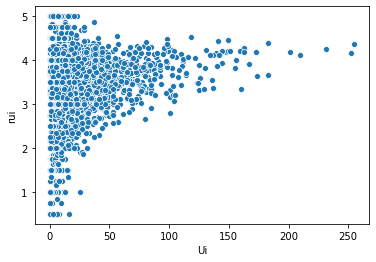

In [260]:
sns.scatterplot(x='Ui', y='rui', data = top);

In [266]:
s = top[top['rui'] == 5]
s.sort_values(by='Ui', ascending=False)

,title,rui,Ui,movieId,release_year,decade
4296,"Sandlot, The (1993)",5.0,23.0,5103.0,1993.0,1990.0
4911,Terms of Endearment (1983),5.0,20.0,1958.0,1983.0,1980.0
4661,Spotlight (2015),5.0,18.0,142488.0,2015.0,2010.0
2410,"Hustler, The (1961)",5.0,16.0,3468.0,1961.0,1960.0
5331,Very Bad Things (1998),5.0,15.0,2387.0,1998.0,1990.0
...,...,...,...,...,...,...
3683,Open Hearts (Elsker dig for evigt) (2002),5.0,0.0,6192.0,2002.0,2000.0
3672,"One I Love, The (2014)",5.0,0.0,113829.0,2014.0,2010.0
1524,Dylan Moran: Monster (2004),5.0,0.0,92494.0,2004.0,2000.0
3658,On the Ropes (1999),5.0,0.0,2824.0,1999.0,1990.0


In [267]:
df

,uid,iid,rui,est,details,Iu,Ui,err,movieId,title,genres
0,140,4995,5.0,4.0,{'was_impossible': False},445,98,1.0,4995,"Beautiful Mind, A (2001)",Drama|Romance
1,161,4995,3.0,4.0,{'was_impossible': False},28,98,1.0,4995,"Beautiful Mind, A (2001)",Drama|Romance
2,132,4995,3.0,3.5,{'was_impossible': False},264,98,0.5,4995,"Beautiful Mind, A (2001)",Drama|Romance
3,256,4995,5.0,4.5,{'was_impossible': False},131,98,0.5,4995,"Beautiful Mind, A (2001)",Drama|Romance
4,307,4995,3.0,3.5,{'was_impossible': False},734,98,0.5,4995,"Beautiful Mind, A (2001)",Drama|Romance
...,...,...,...,...,...,...,...,...,...,...,...
25204,567,152071,1.5,2.0,{'was_impossible': False},292,0,0.5,152071,Race (2016),Drama
25205,408,87785,3.5,4.0,{'was_impossible': False},103,1,0.5,87785,Takers (2010),Action|Crime|Thriller
25206,599,43,3.0,2.5,{'was_impossible': False},1870,7,0.5,43,Restoration (1995),Drama
25207,600,3004,2.5,2.5,{'was_impossible': False},546,10,0.0,3004,"Bachelor, The (1999)",Comedy|Romance


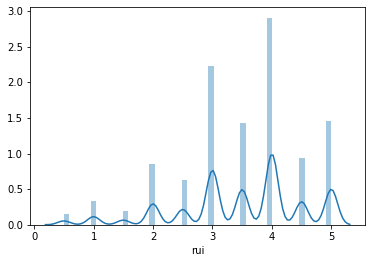

In [269]:
sns.distplot(df['rui'])